In [96]:
%pip install SciencePlots

Note: you may need to restart the kernel to use updated packages.


In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
plt.style.use('science')

In [99]:
pos_colors = {
    "noun": "blue",
    "verb": "green",
    "adjective": "orange",
    "adverb": "red"
}

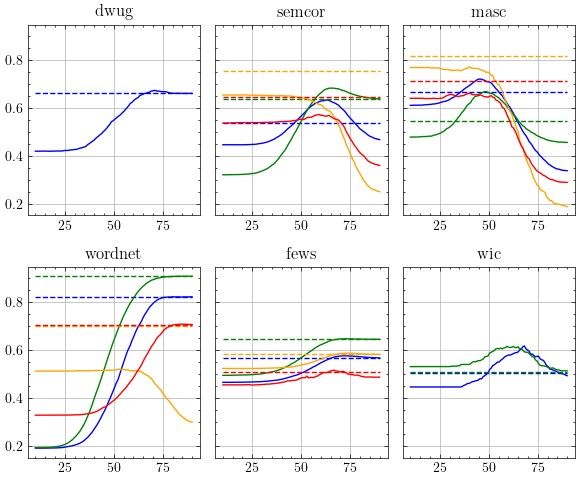

In [113]:
fig, axis = plt.subplots(2, 3, sharey=True, figsize=(6, 5))
axis = axis.flatten()
for idx, exp in enumerate(["dwug", "semcor", "masc", "wordnet", "fews", "wic"]):
    for pos in ["noun", "verb", "adjective", "adverb"]:
        data = pd.read_json(f"{exp}.{pos}.predict.json", lines=True)
        if not data.shape[0]:
            continue
        x = []
        y = []
        for i in np.linspace(10, 90, 100):
            data["pred"] = "different"
            data.loc[data.score > i, "pred"] = "identical"
            x.append(i)
            y.append(sum(data.LABEL == data.pred)/data.shape[0])
        axis[idx].plot(x, y, color=pos_colors[pos])
        axis[idx].hlines(data.LABEL.value_counts().max()/data.shape[0], xmin=10, xmax=90, linestyles='--', color=pos_colors[pos])
        axis[idx].set_title(exp)
        axis[idx].grid(True)
plt.tight_layout()